In [1]:
import os
import cv2
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'jpg'
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import pandas as pd
from PIL import Image
from shutil import copyfile
import time

In [2]:
def roundN(x,N):
    if isinstance(x, int) or isinstance(x,float):
        new_x = np.round(x, N-1-np.int_(np.floor(np.log10(np.abs(x)))))
    else:
        new_x = [np.round(x2, N-1-np.int_(np.floor(np.log10(np.abs(x2))))) \
                 if x2>0 else x2 for x2 in x]
    return np.asarray(new_x)

In [3]:
# Specify where all images are stored

src_folder_copy = os.path.join(os.getcwd(),'../Donors1_6_cropped_with_DFI_labels')


# copy files to new folder?
dont_copy = False

# read in DFI, sample number from DFIs.csv
folder = src_folder_copy
    
full_folder = os.path.join('./', folder)

annotations_filename = os.path.join(full_folder,
                                    'DFIs.csv')

annotations = pd.read_csv(annotations_filename, header=0)

print('%s total imgs (20%% = %d)' % 
      (len(annotations['DFI']), (len(annotations['DFI'])/5)))

print(annotations['sample'].value_counts())

# remove the indices of images with tail overlap, poor background, otherwise bad
bad_img_inds= []

annotations = annotations.drop(annotations.index[bad_img_inds])

n_samples = len(np.unique(annotations['sample']))
# print('n_samples = %s \n' % n_samples)

sample_names = np.unique(annotations['sample'])

# print(annotations['sample'].value_counts())

img_files0 = [f for f in os.listdir(full_folder) if f.endswith('jpg')]
img_files0 = np.delete(img_files0,bad_img_inds)

annotations['img_names'] = img_files0

annotations2 = annotations.copy()
    
# print(annotations2['sample'].value_counts())
# print(len(annotations2))

1064 total imgs (20% = 212)
S1    507
S2    150
S6    134
S3    111
S4     89
S5     73
Name: sample, dtype: int64


## select fraction of data to look at
- useful when analyzing learning curve (lower fraction of images used in training yields lower performance)
- make copies of images into new folders

In [4]:
frac = 1

annotations3 = pd.DataFrame()

for sample_num in range(n_samples):
    
    temp = annotations2[annotations2['sample'].values == sample_names[sample_num]]
            
    temp2 = temp.sample(frac=frac, random_state=42)
    
    annotations3 = annotations3.append(temp2,ignore_index = True)
    
all_DFI = annotations3['DFI'].values

all_sample = annotations3['sample'].values

all_bad = annotations3['bad'].values
all_good = annotations3['good'].values

all_name = annotations3['zimg_name'].values

img_files = annotations3['img_names'].values

img_nums = np.arange(len(img_files))

print('len img files = %s' % len(img_files))

print('%s total imgs (20%% = %d)' % 
      (len(annotations3['DFI']), (len(annotations3['DFI'])/5)))

print(annotations3['sample'].value_counts())

# now sort through and copy images to new folders
for i in range(1,n_samples+2):

    if i<=n_samples:
        all_DFI_final_test = np.asarray([d for ii,d in enumerate(all_DFI) \
                               if str(i) in all_sample[ii]])

        img_files_final_test = np.asarray([d for ii,d in enumerate(img_files) \
                                 if str(i) in all_sample[ii]])
        
        all_DFI_train = np.asarray([d for ii,d in enumerate(all_DFI) \
                               if str(i) not in all_sample[ii]])

        img_files_train = np.asarray([d for ii,d in enumerate(img_files) \
                                 if str(i) not in all_sample[ii]])
        

        train_inds = np.arange(0,len(all_DFI_train))
        test_inds = train_inds[0::5]
        train_inds = np.delete(train_inds,test_inds.tolist(),axis=None)

        final_test_inds = np.arange(0,len(all_DFI_final_test))
        
        # create labels (DFI values)
        test_labels = all_DFI_train[test_inds]
        train_labels = all_DFI_train[train_inds]
        final_test_labels = all_DFI_final_test

        # make folders to move files into
        folder_train = os.path.join(os.getcwd(), 'set'+str(i), 'train', 'class0')
        folder_test = os.path.join(os.getcwd(), 'set'+str(i), 'test', 'class0')
        folder_final_test = os.path.join(os.getcwd(), 'set'+str(i),'final_test','class0')

        if not os.path.exists(folder_train) and not dont_copy:
            os.makedirs(folder_train)

        if not os.path.exists(folder_test) and not dont_copy:
            os.makedirs(folder_test)

        if not os.path.exists(folder_final_test) and not dont_copy:
            os.makedirs(folder_final_test)

        df = pd.DataFrame(train_labels)
        df2 = pd.DataFrame(test_labels)
        df3 = pd.DataFrame(final_test_labels)

        if not dont_copy:
            df.to_csv(os.path.join(folder_train,'labels_train.csv'))
            df2.to_csv(os.path.join(folder_test,'labels_test.csv'))
            df3.to_csv(os.path.join(folder_final_test,'labels_final_test.csv'))

            # move imgs
            for v in (train_inds):
                src = full_folder + '/' + img_files_train[v]

                dst = folder_train + '/' + \
                    img_files_train[v].replace('img', 'img%03d' % (img_nums[v]))

                copyfile(src,dst)

            for v in (test_inds):
                src = full_folder + '/' + img_files_train[v]

                dst = folder_test + '/' + \
                    img_files_train[v].replace('img', 'img%03d' % (img_nums[v]))

                copyfile(src,dst)
                
            for v in (final_test_inds):
                src = full_folder + '/' + img_files_final_test[v]

                dst = folder_final_test + '/' + \
                    img_files_final_test[v].replace('img', 'img%03d' % (img_nums[v]))

                copyfile(src,dst)
                
    else:        
        all_DFI_train = all_DFI
        img_files_train = img_files

        train_inds = np.arange(0,len(all_DFI_train))
        test_inds = train_inds[0::5]
        final_test_inds = train_inds[1::5]
        
        train_inds = np.delete(train_inds,
                               test_inds.tolist()+final_test_inds.tolist(),
                               axis=None)
        
        
        # create labels (DFI values)
        test_labels = all_DFI_train[test_inds]
        train_labels = all_DFI_train[train_inds]
        final_test_labels = all_DFI_train[final_test_inds]

        # make folders to move files into
        folder_train = os.path.join(os.getcwd(), 'set'+str(i), 'train', 'class0')
        folder_test = os.path.join(os.getcwd(), 'set'+str(i), 'test', 'class0')
        folder_final_test = os.path.join(os.getcwd(), 'set'+str(i),'final_test','class0')

        if not os.path.exists(folder_train) and not dont_copy:
            os.makedirs(folder_train)

        if not os.path.exists(folder_test) and not dont_copy:
            os.makedirs(folder_test)

        if not os.path.exists(folder_final_test) and not dont_copy:
            os.makedirs(folder_final_test)

        df = pd.DataFrame(train_labels)
        df2 = pd.DataFrame(test_labels)
        df3 = pd.DataFrame(final_test_labels)

        if not dont_copy:
            df.to_csv(os.path.join(folder_train,'labels_train.csv'))
            df2.to_csv(os.path.join(folder_test,'labels_test.csv'))
            df3.to_csv(os.path.join(folder_final_test,'labels_final_test.csv'))

            # move imgs
            for v in (train_inds):
                src = full_folder + '/' + img_files_train[v]

                dst = folder_train + '/' + \
                    img_files_train[v].replace('img', 'img%03d' % (img_nums[v]))

                copyfile(src,dst)

            for v in (test_inds):
                src = full_folder + '/' + img_files_train[v]

                dst = folder_test + '/' + \
                    img_files_train[v].replace('img', 'img%03d' % (img_nums[v]))

                copyfile(src,dst)
                
            for v in (final_test_inds):
                src = full_folder + '/' + img_files_train[v]

                dst = folder_final_test + '/' + \
                    img_files_train[v].replace('img', 'img%03d' % (img_nums[v]))

                copyfile(src,dst)
                
##  ----------- end copy code from bottom page

len img files = 1064
1064 total imgs (20% = 212)
S1    507
S2    150
S6    134
S3    111
S4     89
S5     73
Name: sample, dtype: int64


## plot DFI for each Donor

DFI mean = 0.096
DFI mean = 0.087
DFI mean = 0.117
DFI mean = 0.115
DFI mean = 0.135
DFI mean = 0.117


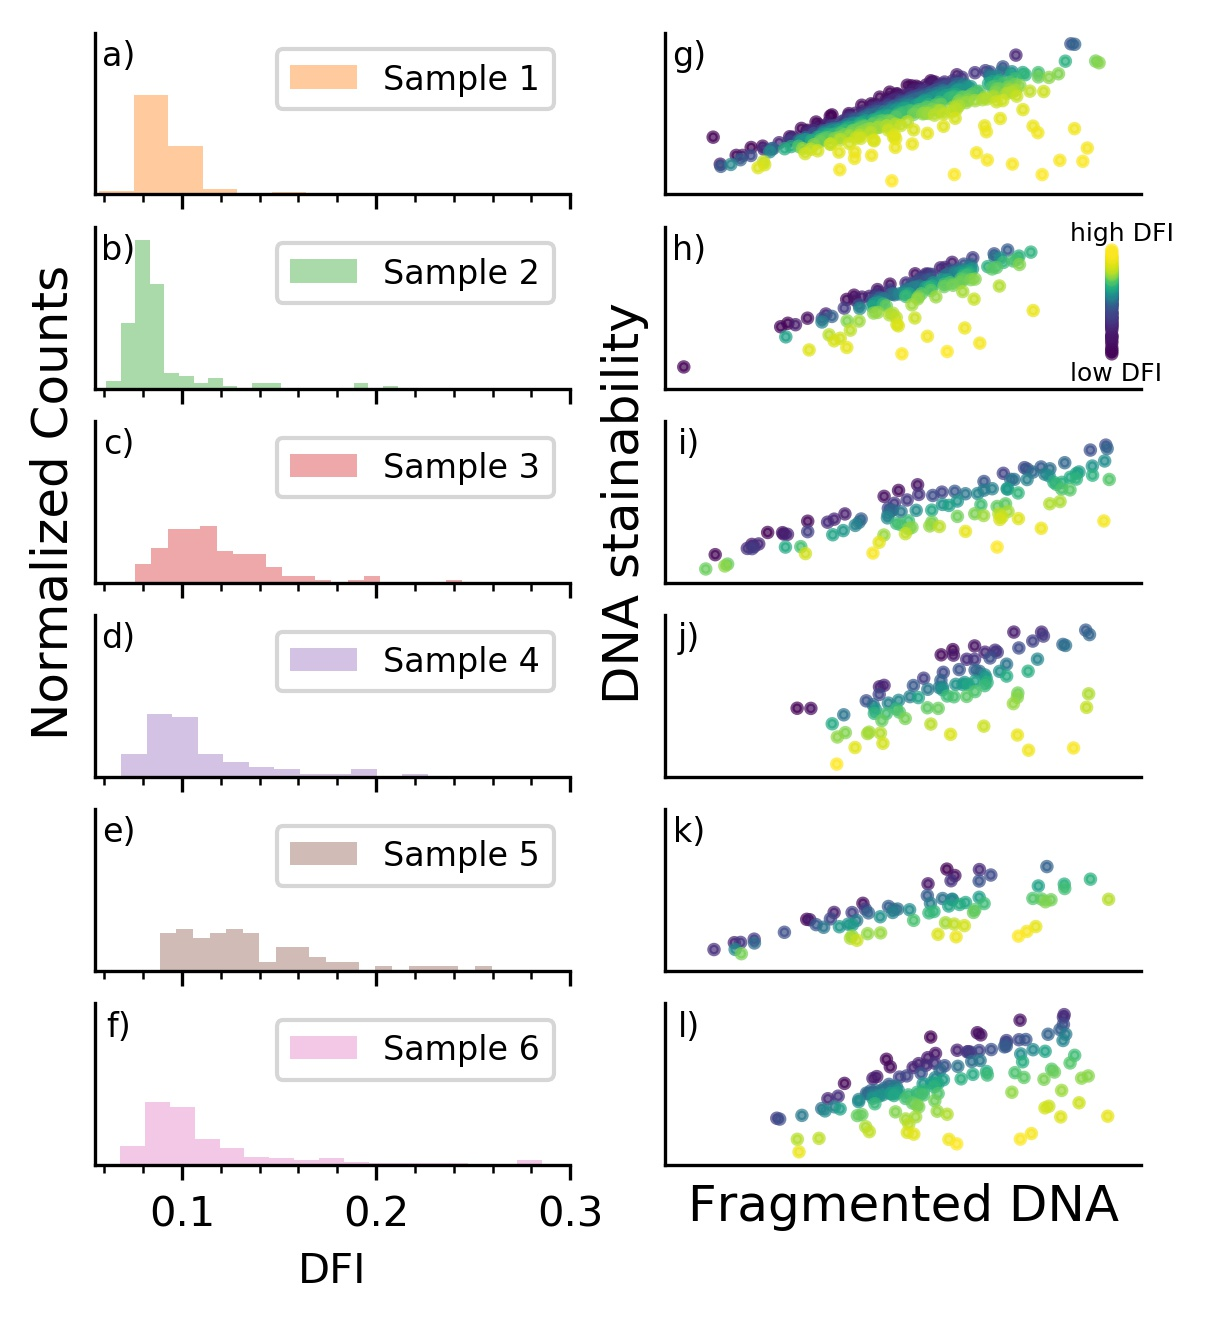

In [5]:
plt.figure(figsize=(4.5,5),dpi=300)

all_DFI2 = np.asarray(all_DFI)
all_good2 = np.asarray(all_good)
all_bad2 = np.asarray(all_bad)

cmap = plt.cm.get_cmap('viridis')

N = len(all_DFI2)

colors = cmap(np.linspace(0,1,N))

DFI_inds = np.argsort(all_DFI2)


n_samples = 6


plot_label1 = ['a','b','c','d','e','f']
plot_iter = range(1,n_samples*2+1,2)



for i in range(1,n_samples+1):
    ax = plt.subplot(n_samples,2,plot_iter[i-1])

    plot_DFI = [d for ii,d in enumerate(all_DFI2) if str(i) in all_sample[ii]]
    plt.hist(plot_DFI, bins=20, density=True, alpha=.4, color=('C%s' % i), 
             label=('Sample %s' % i))
    
    print('DFI mean = %.3f' % np.mean(plot_DFI))
    ax.set_yticks([])
    ax.set_xlim(.055,.3)
    ax.set_ylim(0,55)

    if i==n_samples//2:
        plt.ylabel('Normalized Counts',size=12)
        
    if i==n_samples:
        plt.xlabel('DFI')
        
    else:
        ax.set_xticklabels([])

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        
    ax.annotate(
        plot_label1[i-1]+')', 
        xy=(0.05, 0.8),  xycoords='axes fraction',
        size=8,
        wrap=True, ha='center')
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
#     plt.tight_layout()

    plt.legend(prop={'size': 8})
    
plot_label2 = ['g','h','i','j','k','l']

plot_iter = range(2,n_samples*2+1,2)
for i in range(1,n_samples+1):
    ax = plt.subplot(n_samples,2,plot_iter[i-1])

    plot_DFI = np.asarray([d for ii,d in enumerate(all_DFI2) if str(i) in all_sample[ii]])

    DFI_inds2 = np.argsort(plot_DFI)
    N = len(DFI_inds2)
    colors = cmap(np.linspace(0,1,N))
    
    plot_good = np.asarray([d for ii,d in enumerate(all_good2) if str(i) in all_sample[ii]])
    plot_bad = np.asarray([d for ii,d in enumerate(all_bad2) if str(i) in all_sample[ii]])
    
    plt.scatter(plot_bad[DFI_inds2], plot_good[DFI_inds2], 
                s=5, c=colors, alpha=0.7, 
                label=('Sample%s' % i))
    
    if i==2:
        good_inds = np.argsort(plot_good)
        good_inds = good_inds[1::]
        N = len(good_inds)
        colors = cmap(np.linspace(0,1,N))
        
        plt.scatter(1.2*np.max(plot_bad[good_inds])*np.ones_like(
            plot_good[good_inds]),
                   plot_good[good_inds],
                   s=5, c=colors, alpha=0.7)
        
        ax.annotate(
            'high DFI ', 
            xy=(0.85, 0.92),  xycoords='axes fraction',
            size=6,
            wrap=True, ha='left')
        
        ax.annotate(
            'low DFI', 
            xy=(0.85, 0.05),  xycoords='axes fraction',
            size=6,
            wrap=True, ha='left')
        
        
    ax.set_ylim(0,800000)
    ax.set_xlim(4000,80000)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.annotate(
    plot_label2[i-1]+')', 
    xy=(0.05, 0.8),  xycoords='axes fraction',
    size=8,
    wrap=True, ha='center')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i==n_samples:
        plt.xlabel('Fragmented DNA',size=12)
        
    if i==n_samples//2:
        plt.ylabel('DNA stainability',size=12) 
    
# plt.tight_layout()

plt.show()